# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb/issues/7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [1]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.

> NOTE: We're using blogs from PMarca (Marc Andreessen) as our sample data. This data is largely irrelevant as we want to focus on the mechanisms of RAG, which includes out data's shape and quality - but not specifically what the contents of the data are. 


In [3]:
#text_loader = TextFileLoader("data/PMarcaBlogs.txt")
#documents = text_loader.load_documents()
pdf_loader = TextFileLoader("data/budget_speech.pdf")
documents = pdf_loader.load_documents()
len(documents)

1

In [4]:
print(documents[0][:100])

GOVERNMENT OF INDIA
BUDGET 2025-2026
SPEECH
OF
NIRMALA SITHARAMAN
MINISTER OF FINANCE
February 1,  2


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [5]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

117

Let's take a look at some of the documents we've managed to split.

In [6]:
split_documents[0:1]

['GOVERNMENT OF INDIA\nBUDGET 2025-2026\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2025 \nCONTENTS  \n \nPART – A \n Page No.  \nIntroduction  1 \nBudget Theme  1 \nAgriculture as the 1st engine  3 \nMSMEs as the 2nd engine  6 \nInvestment as the 3rd engine  8 \nA. Investing in People  8 \nB. Investing in  the Economy  10 \nC. Investing in Innovation  14 \nExports as the 4th engine  15 \nReforms as the Fuel  16 \nFiscal Policy  18 \n \n \nPART – B \nIndirect taxes  20 \nDirect Taxes   23 \n \nAnnexure to Part -A 29 \nAnnexure to Part -B 31 \n \n   \n \nBudget 202 5-2026 \n \nSpeech of  \nNirmala Sitharaman  \nMinister of Finance  \nFebruary 1 , 202 5 \nHon’ble Speaker,  \n I present the Budget for 2025 -26. \nIntroduction  \n1. This Budget continues our Government ’s efforts to:  \na) accelerate growth,  \nb) secure inclusive development,  \nc) invigorate private sector investments,  \nd) uplift household sentiments, and \ne) enhance spending power of India’s ri

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [7]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?  
2. What technique does OpenAI use to achieve this?  


> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #2!

**Q. 1 Is there any way to modify this dimentions?**  
*Ans:* Yes, By default, the length of the embedding vector is 1536 for'text-embedding-3-small' model. OpenAI allows you to request a custom embedding dimension using the *dimensions* parameter when making API calls. You can specify any integer value between 1 and 1536 (the default maximum dimension). 
 
{  
  "input": "Your text here",  
  "model": "text-embedding-3-small",  
  "dimensions": 256  // Or any value between 1-1536  
}  

Note: Dimension parameter only supported in 'text-embedding-3' and later models


**2. What technique does OpenAI use to achieve this?**  
*Ans:* OpenAI achieves dimension reduction using a technique called "matrix projection." The full model produces the complete 1536-dimension embedding, but when a smaller dimension is requested, it applies a linear transformation (essentially multiplying by a projection matrix) to map the full embedding down to the requested size while preserving as much of the semantic information as possible.  

This approach is more sophisticated than simple truncation, as it preserves more of the embedding's semantic properties across the reduced dimensions. The projection matrices are carefully designed during training to maintain the quality of the embeddings even at reduced dimensions.  

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [8]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

**Q.2 What are the benefits of using an `async` approach to collecting our embeddings?**  
**Ans:**    

***Synchronous (Sync):*** Executes operations one after another. When one task starts, your program waits for it to complete before moving to the next task. This creates a sequential, blocking pattern.  
***Asynchronous (Async):*** Allows multiple operations to progress in parallel. When a task would normally cause waiting (like an API call), your program can "pause" that task and work on something else, returning to the first task when it's ready.  

**Benifits** 
- Can process multiple embeddings requests concurrently. As we are embedding a list of texts, async lets you call the embedding function on all of them in parallel, rather than waiting for each one to finish one-by-one.
- Reduce wait time, instead of blocking while waiting for API response, code can perform other tasks.
- Efficient resource usage, while waiting for embedding responses, CPU isn't idle, it can process other parts of code
- Better Scalability - As your dataset grows, async becomes increasingly beneficial. Processing 1,000 texts synchronously could take minutes, while async might complete in seconds.

So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [17]:
#vector_db.search_by_text("What is the 'Michael Eisner Memorial Weak Executive Problem'?", k=3)
vector_db.search_by_text("Saksham Anganwadi and Poshan 2.0", k=3)

[(' and build our ecosystem for solar PV cells, EV batteries, motors \nand controllers, electrolyzers, wind turbines, very high voltage transmission \nequipment and grid scale batteries.   \nInvestment as the 3rd engine  \n39. Now, I move to Investment as the 3rd engine, which encompasses \ninvesting in people, investing in the economy and investing in innovation.  \nA. Investing in People  \nSaksham Anganwadi and Poshan 2.0  \n40. The Saksham Anganwadi and Poshan 2.0 programme provides \nnutritional support to more than 8 crore children, 1 crore pregnant women and \nlactating mothers all over the country, and about 20 lakh adolescent girls in \naspirational districts and the north -east re gion. The cost norms for the \nnutritional support will be enhanced appropriately.  \nAtal Tinkering Labs  \n41. Fifty thousand Atal Tinkering Labs will be set up in Government  schools \nin next 5 years to cultivate the spirit of curiosity and innovation, and foster a \nscientific temper among youn

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4o-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

**Q.3 When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?**  
**Ans:**  
* Seed -> Open AI Models like gpt-4, gpt-3.5 supports seed parameter, which controls randomness and generates same output (given the same input + temperature) 
* Temperature ->  lower temperature makes responses more repeatable.
* Top_p: Set to a lower value like 0.1 to reduce randomness
* Frequency penalty and presence penalty: Set to 0 to prevent arbitrary variations
* For structured data, enabling JSON mode forces the model to return valid, consistently structured JSON:


### Creating and Prompting OpenAI's `gpt-4o-mini`!

Let's tie all these together and use it to prompt `gpt-4o-mini`!

In [11]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

In [12]:
print(response)

The best way to write a loop in Python depends on what you want to achieve. Python offers several types of loops, most commonly `for` loops and `while` loops. Here are some guidelines for writing clear and efficient loops:

### 1. **Using `for` loops**:
`for` loops are often used when you have a known range or collection to iterate over. Here’s a basic example of a `for` loop:

```python
# Example: Iterating over a list
fruits = ['apple', 'banana', 'cherry']
for fruit in fruits:
    print(fruit)
```

### 2. **Using `while` loops**:
`while` loops are used when the number of iterations is not known beforehand, and you want to loop until a certain condition is met.

```python
# Example: Using a while loop
count = 0
while count < 5:
    print(count)
    count += 1
```

### 3. **Avoiding Infinite Loops**:
Be careful when using `while` loops. Always ensure that there is a clear exit condition to prevent infinite loops.

### 4. **Using Loop Control Statements**:
You can use `break` to exit th

## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [14]:
RAG_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query.

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""


user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)

        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = rag_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        return {"response" : self.llm.run([formatted_system_prompt, formatted_user_prompt]), "context" : context_list}

#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

What is that strategy called?

> NOTE: You can look through ["Accessing GPT-3.5-turbo Like a Developer"](https://colab.research.google.com/drive/1mOzbgf4a2SP5qQj33ZxTz2a01-5eXqk2?usp=sharing) for an answer to this question if you get stuck!

**Q.4 What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?**

**What is that strategy called?**

**Ans:**  Chain-of-Thought Prompting   
This is the primary strategy for encouraging more thoughtful, detailed responses. It involves explicitly asking the model to work through its reasoning step by step before arriving at a conclusion.
Instead of: "What's the answer to this math problem?"  
Use: "Think through this math problem step by step, showing your reasoning at each stage before giving the final answer."  

Chain-of-thought prompting significantly improves performance on complex reasoning tasks by:  
* Breaking complex problems into smaller, more manageable parts
* Allowing the model to catch errors in its own reasoning
* Providing transparency into how the model reached its conclusion
* Encouraging deeper exploration of the problem space

Other effective strategies include:  
  
Few-shot exemplars - Providing examples of detailed responses you want to see  
Role prompting - "Respond as an expert who carefully considers all aspects of this question"  

In [2]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

NameError: name 'RetrievalAugmentedQAPipeline' is not defined

In [19]:
# retrieval_augmented_qa_pipeline.run_pipeline("What is the 'Michael Eisner Memorial Weak Executive Problem'?")
retrieval_augmented_qa_pipeline.run_pipeline("Saksham Anganwadi and Poshan 2.0")

{'response': 'The Saksham Anganwadi and Poshan 2.0 programme provides nutritional support to more than 8 crore children, 1 crore pregnant women and lactating mothers all over the country, and about 20 lakh adolescent girls in aspirational districts and the north-east region. The cost norms for the nutritional support will be enhanced appropriately.',
 'context': [(' and build our ecosystem for solar PV cells, EV batteries, motors \nand controllers, electrolyzers, wind turbines, very high voltage transmission \nequipment and grid scale batteries.   \nInvestment as the 3rd engine  \n39. Now, I move to Investment as the 3rd engine, which encompasses \ninvesting in people, investing in the economy and investing in innovation.  \nA. Investing in People  \nSaksham Anganwadi and Poshan 2.0  \n40. The Saksham Anganwadi and Poshan 2.0 programme provides \nnutritional support to more than 8 crore children, 1 crore pregnant women and \nlactating mothers all over the country, and about 20 lakh ado

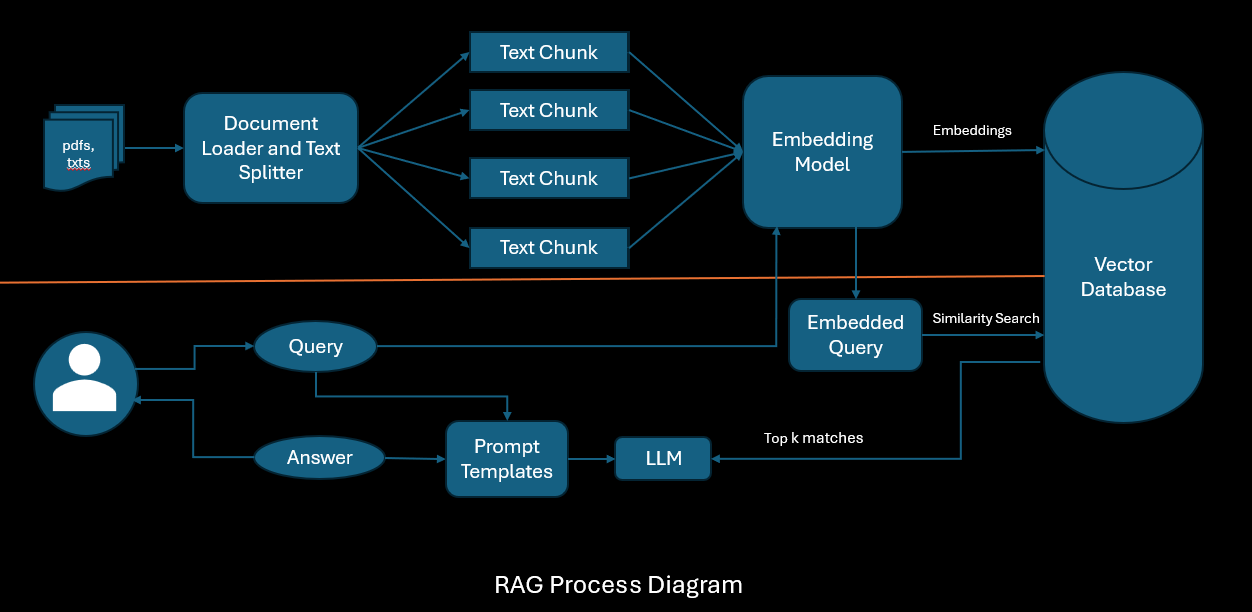

In [3]:
from IPython.display import Image
Image(filename='images/RAG Process Diagram.png')

### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database

While these are suggestions, you should feel free to make whatever augmentations you desire! 

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

**Using New Distance Metric**
Eucledian Distance - Computes the Eucledian (L2) distance between two Vectors

In [ ]:
import numpy as np
def euclidean_distance(vector_a: np.array, vector_b: np.array) -> float:
    """Computes the Euclidean (L2) distance between two vectors.
    
    Returns a value >= 0, where 0 means vectors are identical.
    Lower values indicate greater similarity.
    """
    return np.linalg.norm(vector_a - vector_b)


In [22]:
import numpy as np
from collections import defaultdict
from typing import List, Tuple, Callable
from aimakerspace.openai_utils.embedding import EmbeddingModel
import asyncio

# Replaced the cosine similarity with euclidean_distance function:
def euclidean_distance(vector_a: np.array, vector_b: np.array) -> float:
    """Computes the Euclidean (L2) distance between two vectors."""
    return np.linalg.norm(vector_a - vector_b)


class VectorDatabase:
    def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()

    def insert(self, key: str, vector: np.array) -> None:
        self.vectors[key] = vector

    def search(
        self,
        query_vector: np.array,
        k: int,
        distance_measure: Callable = euclidean_distance,
    ) -> List[Tuple[str, float]]:
        scores = [
            (key, distance_measure(query_vector, vector))
            for key, vector in self.vectors.items()
        ]
        return sorted(scores, key=lambda x: x[1])[:k]  # sort by distance, lower is better

    def search_by_text(
        self,
        query_text: str,
        k: int,
        distance_measure: Callable = euclidean_distance,
        return_as_text: bool = False,
    ) -> List[Tuple[str, float]]:
        query_vector = self.embedding_model.get_embedding(query_text)
        results = self.search(query_vector, k, distance_measure)
        return [result[0] for result in results] if return_as_text else results

    def retrieve_from_key(self, key: str) -> np.array:
        return self.vectors.get(key, None)

    async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self


    list_of_text = [
        "I like to eat broccoli and bananas.",
        "I ate a banana and spinach smoothie for breakfast.",
        "Chinchillas and kittens are cute.",
        "My sister adopted a kitten yesterday.",
        "Look at this cute hamster munching on a piece of broccoli.",
    ]

    vector_db = VectorDatabase()
    vector_db = asyncio.run(vector_db.abuild_from_list(list_of_text))
    k = 2

    searched_vector = vector_db.search_by_text("I think fruit is awesome!", k=k)
    print(f"Closest {k} vector(s):", searched_vector)

    retrieved_vector = vector_db.retrieve_from_key(
        "I like to eat broccoli and bananas."
    )
    print("Retrieved vector:", retrieved_vector)

    relevant_texts = vector_db.search_by_text(
        "I think fruit is awesome!", k=k, return_as_text=True
    )
    print(f"Closest {k} text(s):", relevant_texts)


Closest 2 vector(s): [('I like to eat broccoli and bananas.', np.float64(1.0743919730919849)), ('I ate a banana and spinach smoothie for breakfast.', np.float64(1.18577649219102))]
Retrieved vector: [-0.00360005 -0.07098462 -0.02816089 ...  0.01615882 -0.02056681
  0.00407682]
Closest 2 text(s): ['I like to eat broccoli and bananas.', 'I ate a banana and spinach smoothie for breakfast.']
